In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import sklearn as skl
import sklearn.model_selection as skl_ms
import seaborn as sns
import cv2
from PIL import Image
import tensorflow_addons as tfa

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

tfk = tf.keras
tfkl = tf.keras.layers

In [25]:
dataframe = pd.read_csv('/kaggle/input/quality-annotated-dataframe/quality_annotated_dataframe.csv')

In [26]:
dataframe_quality = dataframe[dataframe['quality'] == 0]

filenames = dataframe_quality['file'].to_numpy()
to_remove = np.zeros(filenames.shape[0])

num_duplicates = 0

# Let's remove duplicates
for index in range(filenames.shape[0]):
    # Ignore the last element
    if index == filenames.shape[0] - 1:
        break
    
    filename = filenames[index]
    next_filename = filenames[index + 1]
    
    # Remove extension
    filename = filename.replace('.png', '')
    filename = filename.replace('.jpeg', '')
    next_filename = next_filename.replace('.png', '')
    next_filename = next_filename.replace('.jpeg', '')
    
    # If consecutive filenames refer to the same patient
    if filename[:-2] == next_filename[:-2]:
        to_remove[index + 1] = 1
        num_duplicates = num_duplicates + 1
        index = index + 1
        
dataframe_quality = dataframe_quality[to_remove == 0]
        
print('Removed %d duplicates' % num_duplicates)

dataframe_path = dataframe_quality.copy()
dataframe_path['path'] = '/kaggle/input/training-dataset/train/' + dataframe_path['label'] + '/' + dataframe_path['file']

Removed 1293 duplicates


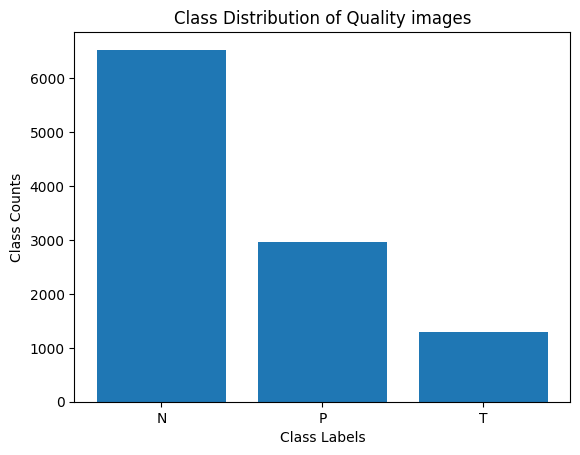

In [27]:
labels = dataframe_path['label']

# Create a bar plot
plt.bar(np.unique(labels), [np.sum(labels == l) for l in np.unique(labels)])

# Add labels and title to the plot
plt.xlabel('Class Labels')
plt.ylabel('Class Counts')
plt.title('Class Distribution of Quality images')

# Display the plot
plt.show()

In [28]:
seed = 3913326
#seed = 451857256
train_path_based, test_path_based = train_test_split(dataframe_path,random_state = seed, test_size=0.2, shuffle=True)
train_path_based, validation_path_based = train_test_split(train_path_based, random_state=seed, test_size=0.1, shuffle=True)

In [29]:
def preprocessing(image):
    if image.shape[-1] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    image = np.uint8(image)

    # Check if background is Standard Radiological Format compliant, otherwise invert colors
    # (the check is performed on the median color along the spine)
    buffer = image / np.max(image)

    median_spine = np.median(buffer[:, buffer.shape[1] // 2])

    if median_spine < 0.5:
        image = cv2.bitwise_not(image)

    # Mist reduction and gamma transformation
    img_equalized = cv2.equalizeHist(image)
    gamma = 1.5
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
                    for i in np.arange(0, 256)]).astype('uint8')
    img_gamma = cv2.LUT(img_equalized, table)

    # Apply Adaptive Contrast Equalization
    clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(img_gamma)

    # Apply Gaussian Smoothing
    gaussian_img = cv2.GaussianBlur(clahe_img, (5,5), 0)
    gaussian_img = gaussian_img.reshape(gaussian_img.shape[0], gaussian_img.shape[1], 1)
    
    # Need to duplicate channel to make it RGB to use a pretrained model
    rgb_duplicated = np.repeat(gaussian_img, repeats=3, axis=-1)
    
    # Specific preprocessing from densenet
    rescaled = tfk.applications.densenet.preprocess_input(rgb_duplicated)
    
    return rescaled

In [32]:
root_dir = '/kaggle/input/normalpneumoniatubeculosis-qualityannotated'

train_datagen = ImageDataGenerator(preprocessing_function=preprocessing)
# Use flow_from_dataframe method to read images from directory based on dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_path_based,
    directory=root_dir,
    x_col='path',
    y_col='label',
    target_size=(512, 512), # set the target image size
    batch_size=64, # set the batch size
    class_mode='categorical' # set the class mode to categorical for multi-class classification
)


validation_datagen = ImageDataGenerator(preprocessing_function=preprocessing)

# Use flow_from_dataframe method to read images from directory based on dataframe
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_path_based,
    directory=root_dir,
    x_col='path',
    y_col='label',
    shuffle = False,
    target_size=(512, 512), # set the target image size
    batch_size=64, # set the batch size
    class_mode='categorical' # set the class mode to categorical for multi-class classification
)


test_datagen = ImageDataGenerator(preprocessing_function=preprocessing)

# Use flow_from_dataframe method to read images from directory based on dataframe
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_path_based,
    directory=root_dir,
    x_col='path',
    y_col='label',
    shuffle = False,
    target_size=(512, 512), # set the target image size
    batch_size=64, # set the batch size
    class_mode='categorical' # set the class mode to categorical for multi-class classification
)

Found 7769 validated image filenames belonging to 3 classes.
Found 864 validated image filenames belonging to 3 classes.
Found 2159 validated image filenames belonging to 3 classes.


In [33]:
pretrained_model = tfk.applications.DenseNet169(
    input_shape=(512,512,3),
    include_top=False,
    weights="imagenet")

51877672/51877672 [==============================] - 0s 0us/step


In [34]:
for i, layer in enumerate(pretrained_model.layers):
    print(f'{i} - {layer.name}')

0 - input_1
1 - zero_padding2d
2 - conv1/conv
3 - conv1/bn
4 - conv1/relu
5 - zero_padding2d_1
6 - pool1
7 - conv2_block1_0_bn
8 - conv2_block1_0_relu
9 - conv2_block1_1_conv
10 - conv2_block1_1_bn
11 - conv2_block1_1_relu
12 - conv2_block1_2_conv
13 - conv2_block1_concat
14 - conv2_block2_0_bn
15 - conv2_block2_0_relu
16 - conv2_block2_1_conv
17 - conv2_block2_1_bn
18 - conv2_block2_1_relu
19 - conv2_block2_2_conv
20 - conv2_block2_concat
21 - conv2_block3_0_bn
22 - conv2_block3_0_relu
23 - conv2_block3_1_conv
24 - conv2_block3_1_bn
25 - conv2_block3_1_relu
26 - conv2_block3_2_conv
27 - conv2_block3_concat
28 - conv2_block4_0_bn
29 - conv2_block4_0_relu
30 - conv2_block4_1_conv
31 - conv2_block4_1_bn
32 - conv2_block4_1_relu
33 - conv2_block4_2_conv
34 - conv2_block4_concat
35 - conv2_block5_0_bn
36 - conv2_block5_0_relu
37 - conv2_block5_1_conv
38 - conv2_block5_1_bn
39 - conv2_block5_1_relu
40 - conv2_block5_2_conv
41 - conv2_block5_concat
42 - conv2_block6_0_bn
43 - conv2_block6_0_

In [35]:
# Freeze the layers in the base model

pretrained_model.trainable = True

transfer_model = tfk.Sequential(name = 'Q-Dense169MedNoAug')

transfer_model.add(pretrained_model)
transfer_model.add(tfkl.GlobalAveragePooling2D(name='GAP'))
transfer_model.add(tfkl.Dropout(0.35, name='DropoutLayer'))
transfer_model.add(tfkl.Dense(units = 256, activation='relu', name = 'DenseLayer1'))
transfer_model.add(tfkl.Dense(units = 3, activation='softmax', name = 'OutputLayer'))

freeze_layer_limit = 367

# Freeze first layers
for i, layer in enumerate(transfer_model.get_layer('densenet169').layers[:freeze_layer_limit]):
    layer.trainable=False




In [37]:
# Compile the model
transfer_model.compile(loss=tfa.losses.SigmoidFocalCrossEntropy(), optimizer=tfa.optimizers.Yogi(1e-4), metrics='accuracy')

transfer_model.summary()

Model: "Q-Dense169MedNoAug"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 16, 16, 1664)      12642880  
                                                                 
 GAP (GlobalAveragePooling2D  (None, 1664)             0         
 )                                                               
                                                                 
 DropoutLayer (Dropout)      (None, 1664)              0         
                                                                 
 DenseLayer1 (Dense)         (None, 256)               426240    
                                                                 
 OutputLayer (Dense)         (None, 3)                 771       
                                                                 
Total params: 13,069,891
Trainable params: 7,163,139
Non-trainable params: 5,906,752
_____________________________

In [38]:
history_model = transfer_model.fit(
    x = train_generator,
    batch_size = 64,
    epochs = 35,
    validation_data = validation_generator,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True),
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, min_lr=1e-6)
                ]
).history

Epoch 1/35
122/122 [==============================] - 390s 3s/step - loss: 0.0682 - accuracy: 0.8787 - val_loss: 0.0780 - val_accuracy: 0.8692 - lr: 1.0000e-04
Epoch 2/35
122/122 [==============================] - 298s 2s/step - loss: 0.0276 - accuracy: 0.9551 - val_loss: 0.0503 - val_accuracy: 0.9028 - lr: 1.0000e-04
Epoch 3/35
122/122 [==============================] - 297s 2s/step - loss: 0.0146 - accuracy: 0.9764 - val_loss: 0.0220 - val_accuracy: 0.9641 - lr: 1.0000e-04
Epoch 4/35
122/122 [==============================] - 298s 2s/step - loss: 0.0080 - accuracy: 0.9882 - val_loss: 0.0364 - val_accuracy: 0.9606 - lr: 1.0000e-04
Epoch 5/35
122/122 [==============================] - 297s 2s/step - loss: 0.0040 - accuracy: 0.9947 - val_loss: 0.0185 - val_accuracy: 0.9745 - lr: 1.0000e-04
Epoch 6/35
122/122 [==============================] - 299s 2s/step - loss: 0.0034 - accuracy: 0.9955 - val_loss: 0.0214 - val_accuracy: 0.9699 - lr: 1.0000e-04
Epoch 7/35
122/122 [====================

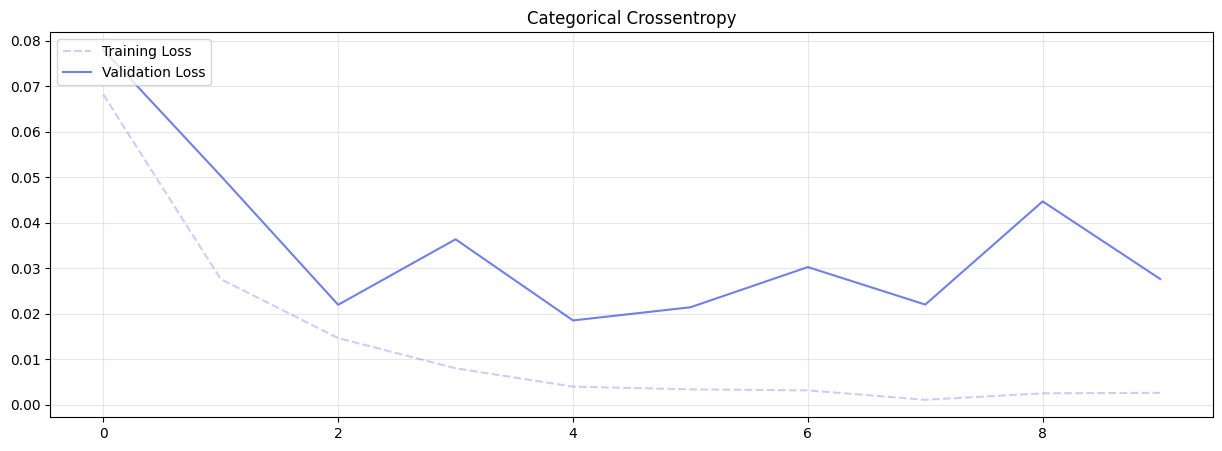

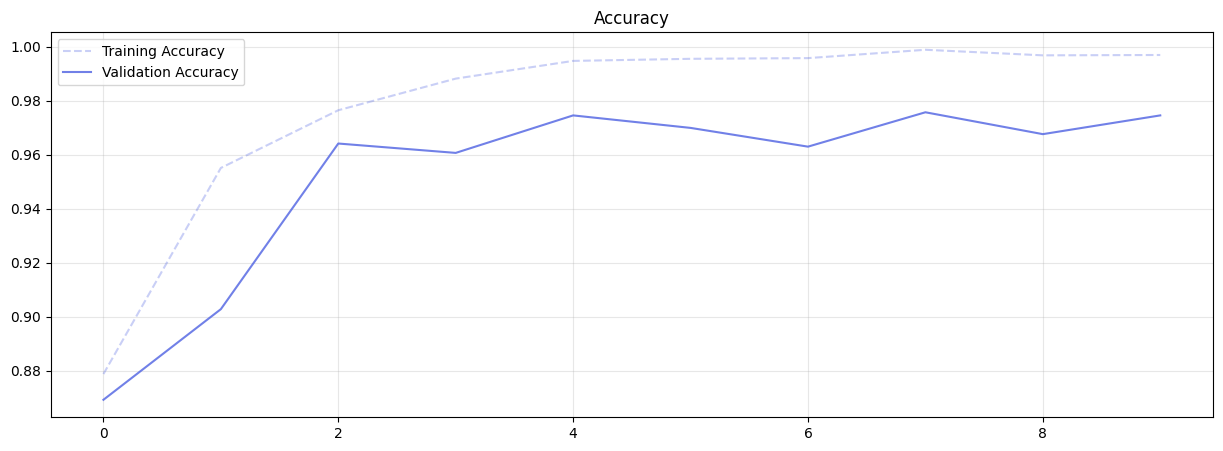

In [39]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history_model['loss'], label='Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_model['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history_model['accuracy'], label = 'Training Accuracy', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_model['val_accuracy'], label='Validation Accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
print("hi")

In [41]:
# Predict the test set with the CNN1
predictions = transfer_model.predict(test_generator)
label_names = {
    0: "N",
    1: "P",
    2: "T"
}
label_classes = label_names.values()
converted_test_labels = np.zeros(test_path_based["label"].shape)
converted_test_labels[test_path_based["label"] == 'N'] = 0
converted_test_labels[test_path_based["label"] == 'P'] = 1
converted_test_labels[test_path_based["label"] == 'T'] = 2 

34/34 [==============================] - 73s 2s/step


In [42]:
prediction_numerical = np.argmax(predictions, axis=-1)

Accuracy: 0.9653
Precision: 0.9491
Recall: 0.9524
F1: 0.9507


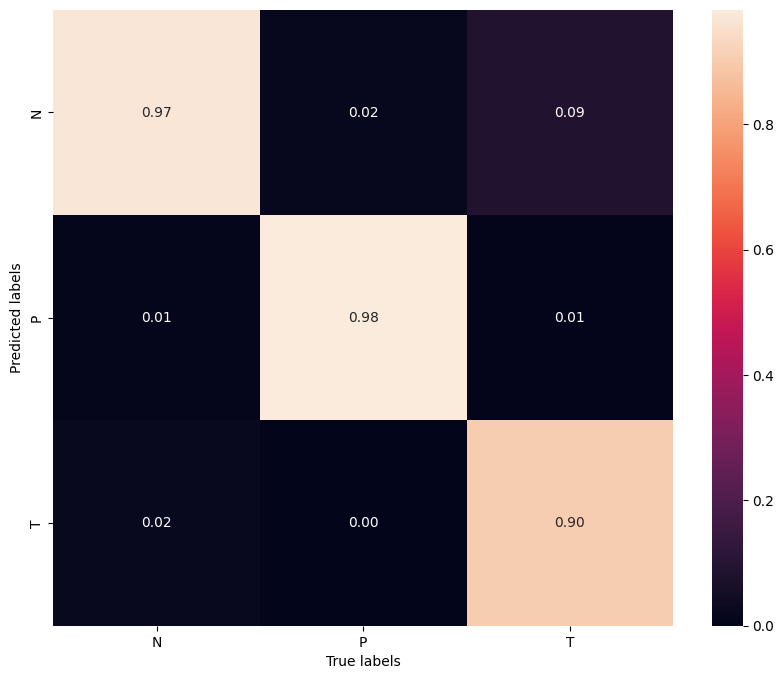

In [43]:
# Compute the confusion matrix
cm = confusion_matrix(converted_test_labels, np.argmax(predictions, axis=-1))
cm_rel = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Compute the classification metrics
accuracy = accuracy_score(converted_test_labels, np.argmax(predictions, axis=-1))
precision = precision_score(converted_test_labels, np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(converted_test_labels, np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(converted_test_labels, np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_rel.T, xticklabels=label_classes, yticklabels=label_classes, annot=True, fmt='.2f')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [44]:
print(tf.__version__)

2.11.0


In [45]:
from sklearn.metrics import classification_report
# generate the classification report
print(classification_report(converted_test_labels, prediction_numerical, target_names=['Normal', 'Pneumonia', 'Tuberculosis']))

              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97      1319
   Pneumonia       0.97      0.98      0.98       577
Tuberculosis       0.90      0.90      0.90       263

    accuracy                           0.97      2159
   macro avg       0.95      0.95      0.95      2159
weighted avg       0.97      0.97      0.97      2159



Apparently, there is a bug with tensorflow versions >= 2.10.0 Efficientnet networks cannot be serialized. I need to retrain the model with tensorflow 2.9.0 to be able to export it.

In [47]:
transfer_model.save('DenseNet169-withoutAug')

In [48]:
!zip -r DenseNet169-withoutAug.zip DenseNet169-withoutAug -r 

  adding: DenseNet169-withoutAug/ (stored 0%)
  adding: DenseNet169-withoutAug/keras_metadata.pb (deflated 97%)
  adding: DenseNet169-withoutAug/variables/ (stored 0%)
  adding: DenseNet169-withoutAug/variables/variables.index (deflated 80%)
  adding: DenseNet169-withoutAug/variables/variables.data-00000-of-00001 (deflated 14%)
  adding: DenseNet169-withoutAug/saved_model.pb (deflated 92%)
  adding: DenseNet169-withoutAug/fingerprint.pb (stored 0%)
  adding: DenseNet169-withoutAug/assets/ (stored 0%)


In [51]:
x = pretrained_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.35)(x)
x = keras.layers.Dense(units = 256, activation='relu')(x)
outputs = keras.layers.Dense(3, activation="softmax")(x)
model_complete = keras.Model(pretrained_model.input, outputs)

model_complete.set_weights(transfer_model.get_weights())
model_complete.compile(loss=tfa.losses.SigmoidFocalCrossEntropy(), optimizer=tfa.optimizers.Yogi(1e-4), metrics='accuracy')
model_complete.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 256, 256, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [52]:
model_complete.save('DenseNet169-withoutAug_expanded')

In [54]:
!zip -r DenseNet169-withoutAug_expanded.zip /kaggle/working/DenseNet169-withoutAug_expanded -r 

updating: kaggle/working/DenseNet169-withoutAug_expanded/ (stored 0%)
updating: kaggle/working/DenseNet169-withoutAug_expanded/keras_metadata.pb (deflated 96%)
updating: kaggle/working/DenseNet169-withoutAug_expanded/variables/ (stored 0%)
updating: kaggle/working/DenseNet169-withoutAug_expanded/variables/variables.index (deflated 81%)
updating: kaggle/working/DenseNet169-withoutAug_expanded/variables/variables.data-00000-of-00001 (deflated 7%)
updating: kaggle/working/DenseNet169-withoutAug_expanded/saved_model.pb (deflated 93%)
updating: kaggle/working/DenseNet169-withoutAug_expanded/fingerprint.pb (stored 0%)
updating: kaggle/working/DenseNet169-withoutAug_expanded/assets/ (stored 0%)
